In [267]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
import random
from sklearn.metrics import f1_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
source_dir = ('/kaggle/input' if os.path.exists('/kaggle') else os.environ.get('KAGGLE_DATA')) + '/digit-recognizer'
for dirname, _, filenames in os.walk(source_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/Users/shirabroner/Documents/DataScience/kaggle-data/digit-recognizer/test.csv
/Users/shirabroner/Documents/DataScience/kaggle-data/digit-recognizer/train.csv
/Users/shirabroner/Documents/DataScience/kaggle-data/digit-recognizer/sample_submission.csv


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [268]:
train_df = pd.read_csv(source_dir + '/train.csv')
test_df = pd.read_csv(source_dir + '/test.csv')
sample_submission_df = pd.read_csv(source_dir + '/sample_submission.csv')

<Axes: xlabel='label'>

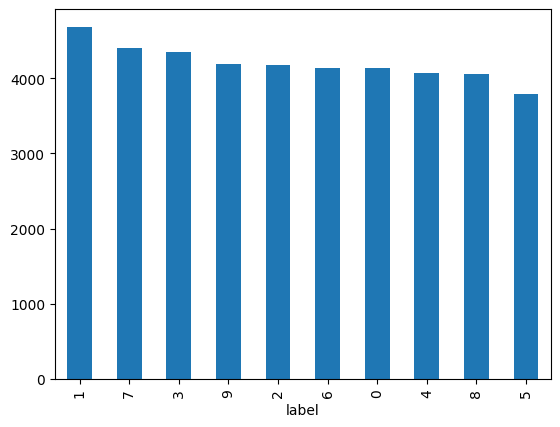

In [269]:
train_df['label'].value_counts().plot.bar()

In [270]:
torch.from_numpy(train_df.filter(train_df.columns[1:]).iloc[0].values).reshape(28, 28).shape

torch.Size([28, 28])

In [271]:
train_df.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


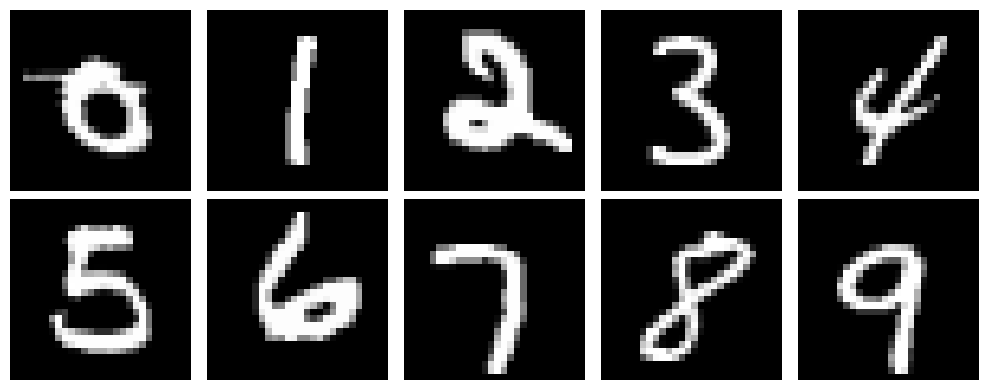

In [272]:
images = train_df.sample(frac=1).reset_index(drop=True).groupby(by='label').first().reset_index(drop=False).filter(train_df.columns[1:]).values.reshape(10, 28, 28)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout() 
plt.show()

In [273]:
label = torch.tensor(train_df['label'])
train = torch.tensor(np.array(train_df.drop(['label'], axis = 1)), dtype=torch.float32).reshape(len(train_df), 1, 28, 28)
train = train / 255

In [274]:
test = torch.tensor(np.array(test_df), dtype=torch.float32).reshape(len(test_df), 1, 28, 28)

In [275]:
X_train, X_val, y_train, y_val = train_test_split(train, label ,test_size = 0.20,random_state = 42, stratify=label)
len(X_train), len(X_val), len(y_train), len(y_val)

(33600, 8400, 33600, 8400)

9


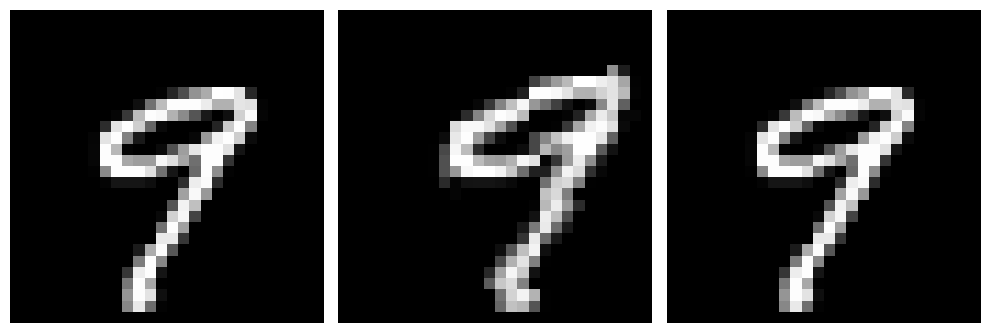

In [277]:
index = random.randint(0, len(X_train))
image =  X_train[index]
print(y_train[index].item())

mean = X_train.mean().item()
std = X_train.std().item()

# Define transformations
transform = v2.Compose([# Convert image to PyTorch tensor,
    v2.RandomResizedCrop(scale=(0.8, 1), size=(28, 28), antialias=True),
    #v2.RandomHorizontalFlip(p=0),
    #v2.Normalize(mean=(mean,), std=(std,)),
    v2.RandomApply([v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2, hue=0.1)], p=0.6),
    #v2.RandomAffine(30, scale=(0.95, 1)),
    v2.RandomRotation(degrees=(-45, 45))
])

#transform = v2.ToTensor()
transform_val = v2.ToTensor() #v2.Normalize(mean=(mean,), std=(std,))
# Assuming 'image' is your 28x28 image
processed_image = transform(image)
processed_val_image = transform_val(image)
images = [image, processed_image, processed_val_image]
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout() 
plt.show()

In [278]:
from transformers import AutoModelForSequenceClassification
from transformers import ResNetConfig, ResNetModel
from transformers import AutoImageProcessor, ResNetForImageClassification

#model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=10, ignore_mismatched_sizes=True)
# Initializing a ResNet resnet-50 style configuration
configuration = ResNetConfig(num_channels=1, num_labels=10, device=device)

# Initializing a model (with random weights) from the resnet-50 style configuration
#model = ResNetForImageClassification(configuration).to(device)

#model.config
#model = AutoModelForSequenceClassification.from_pretrained("microsoft/resnet-50", num_labels=10)

In [280]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class SimpleDropoutCNN(nn.Module):
    def __init__(self):
        super(SimpleDropoutCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)  # Add dropout layer with dropout probability of 0.5

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)  # Apply dropout after the first convolutional layer
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the final fully connected layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Instantiate the model
model = SimpleDropoutCNN().to(device)


In [281]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler

# Define custom dataset class
class DigitImageDataset(Dataset):
    def __init__(self, data, labels, transformer=None):
        self.data = data
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transformer is not None and random.random() > 0.6:
            image = self.transformer(image)
        sample = (image, self.labels[idx])
        return sample

# Assuming you have your data and labels in variables 'data' and 'labels'
# Create an instance of CustomDataset
dataset = DigitImageDataset(X_train, y_train)

# Define batch size
batch_size = 32

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for x1, x2 in dataloader:
    break

In [282]:
sampler = RandomSampler(dataset, replacement=True, num_samples=len(X_train))
train_dataloader = DataLoader(DigitImageDataset(X_train, y_train, transform), batch_size=64, sampler=sampler)
val_dataset = DigitImageDataset(X_val, y_val, transform_val)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [283]:
len(val_dataset)

8400

In [284]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss().to(device)


In [180]:
0.00001

1e-05

In [285]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [286]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [287]:
from  datetime import datetime
from torch.utils.tensorboard import SummaryWriter

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/apply_transformesrs_nonorm_simplecnn_alldata_dropout25_epoch100_degress45{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    epoch_true_pred = 0
    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)            
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            pred = voutputs.argmax(-1)
            epoch_true_pred += torch.sum(pred == vlabels)

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.add_scalars('Validation Metrics',
                    { 'Accuracy' : epoch_true_pred / len(val_dataset)}, #'F1' : f1_score(pred.cpu(), vlabels.cpu()) },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        #torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 0.0 valid 0.8735775351524353
EPOCH 2:
LOSS train 0.0 valid 0.5386351346969604
EPOCH 3:
LOSS train 0.0 valid 0.419257253408432
EPOCH 4:
LOSS train 0.0 valid 0.36505699157714844
EPOCH 5:
LOSS train 0.0 valid 0.314559668302536
EPOCH 6:
LOSS train 0.0 valid 0.2763645350933075
EPOCH 7:
LOSS train 0.0 valid 0.24725310504436493
EPOCH 8:
LOSS train 0.0 valid 0.22244079411029816
EPOCH 9:
LOSS train 0.0 valid 0.20343197882175446
EPOCH 10:
LOSS train 0.0 valid 0.18604212999343872
EPOCH 11:
LOSS train 0.0 valid 0.17663733661174774
EPOCH 12:
LOSS train 0.0 valid 0.15929783880710602
EPOCH 13:
LOSS train 0.0 valid 0.15794818103313446
EPOCH 14:
LOSS train 0.0 valid 0.14088977873325348
EPOCH 15:
LOSS train 0.0 valid 0.13502858579158783
EPOCH 16:
LOSS train 0.0 valid 0.12724292278289795
EPOCH 17:
LOSS train 0.0 valid 0.11806260049343109
EPOCH 18:
LOSS train 0.0 valid 0.11636100709438324
EPOCH 19:
LOSS train 0.0 valid 0.10951381921768188
EPOCH 20:
LOSS train 0.0 valid 0.10699695348739

In [262]:
#new_model = SimpleDropoutCNN()
#new_model.load_state_dict(torch.load('model_20240218_144009_48'))

In [288]:
model.eval()

SimpleDropoutCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [291]:
with torch.no_grad():
    output = model(test.to(device))
    output = output.argmax(-1)
    pass

In [293]:
sample_submission_df['Label'] = output.cpu().numpy()

In [ ]:
sample_submission_df.to_csv('submission.csv', index=False)